# GradCAM Implementation from Scratch

This notebook implements GradCAM (Gradient-weighted Class Activation Mapping) from scratch.

## Components Implemented:

1. **ClassifierOutputTarget**: Specifies which class to generate CAM for
2. **GradCAM**: Main class that computes gradient-weighted activation maps
3. **show_cam_on_image**: Utility to overlay heatmap on original image

## How it works:

1. **Forward Pass**: Capture activations from target layers
2. **Backward Pass**: Compute gradients of target class w.r.t. activations
3. **Weight Calculation**: Global average pooling of gradients gives importance weights
4. **CAM Generation**: Weighted sum of activation maps, followed by ReLU
5. **Visualization**: Resize, normalize, and overlay on original image

In [16]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch
import torch.nn.functional as F
import torchvision.models as models

import torch
import torch.nn as nn
import torchvision.models as models
import glob

# Helper function
import sys
sys.path.append('../')

from utils.datasets import ImageDataset
from utils.visualise import get_edge

In [40]:
# ClassifierOutputTarget Implementation
class ClassifierOutputTarget:
    """
    Target class for GradCAM to specify which class output to compute gradients for.
    """
    def __init__(self, category):
        """
        Args:
            category (int): The target class index
        """
        self.category = category
    
    def __call__(self, model_output):
        """
        Extract the score for the target category from model output.
        
        Args:
            model_output (torch.Tensor): Model output logits of shape (batch_size, num_classes)
        
        Returns:
            torch.Tensor: Score for the target category
        """
        if len(model_output.shape) == 1:
            # Single sample, no batch dimension
            return model_output[self.category]
        # Return the score for target category for all samples in batch
        return model_output[:, self.category]

In [41]:
# GradCAM Implementation
class GradCAM:
    """
    Gradient-weighted Class Activation Mapping (Grad-CAM) implementation.
    
    Generates visual explanations for CNN decisions by computing gradients
    of the target class with respect to feature maps.
    """
    
    def __init__(self, model, target_layers):
        """
        Args:
            model (torch.nn.Module): The CNN model to explain
            target_layers (list): List of layers to extract activations from
        """
        self.model = model
        self.target_layers = target_layers
        self.activations = []
        self.gradients = []
        self.hooks = []
        
        # Register hooks on target layers
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward and backward hooks on target layers."""
        
        def forward_hook(module, input, output):
            """Save activations during forward pass."""
            self.activations.append(output.detach())
        
        def backward_hook(module, grad_input, grad_output):
            """Save gradients during backward pass."""
            self.gradients.append(grad_output[0].detach())
        
        # Register hooks for each target layer
        for layer in self.target_layers:
            self.hooks.append(layer.register_forward_hook(forward_hook))
            self.hooks.append(layer.register_full_backward_hook(backward_hook))
    
    def remove_hooks(self):
        """Remove all registered hooks."""
        for hook in self.hooks:
            hook.remove()
    
    def __call__(self, input_tensor, targets=None):
        """
        Generate GradCAM heatmap.
        
        Args:
            input_tensor (torch.Tensor): Input image tensor of shape (batch_size, C, H, W)
            targets (list): List of ClassifierOutputTarget objects specifying target classes
        
        Returns:
            numpy.ndarray: Heatmap of shape (batch_size, H, W) with values in [0, 1]
        """
        # Clear previous activations and gradients
        self.activations = []
        self.gradients = []
        
        # Ensure input requires gradients
        input_tensor = input_tensor.requires_grad_(True)
        
        # Forward pass
        output = self.model(input_tensor)
        
        # If no targets specified, use the predicted class
        if targets is None:
            targets = [ClassifierOutputTarget(output.argmax(dim=1).item())]
        
        # Zero gradients
        self.model.zero_grad()
        
        # Compute target score (sum if multiple targets)
        target_score = sum([target(output) for target in targets])
        
        # Backward pass to get gradients
        target_score.backward(retain_graph=True)
        
        # Reverse gradients list (they were added in reverse order during backward)
        self.gradients = self.gradients[::-1]
        
        # Process each layer's activations and gradients
        cam_per_layer = []
        for activations, gradients in zip(self.activations, self.gradients):
            # Global average pooling of gradients
            # Shape: (batch, channels, H, W) -> (batch, channels, 1, 1)
            weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
            
            # Weighted combination of activation maps
            # Shape: (batch, channels, H, W)
            weighted_activations = weights * activations
            
            # Sum across channels
            # Shape: (batch, H, W)
            cam = torch.sum(weighted_activations, dim=1)
            
            # Apply ReLU (only positive influences)
            cam = F.relu(cam)
            
            cam_per_layer.append(cam)
        
        # Combine CAMs from all layers (sum and average)
        if len(cam_per_layer) > 1:
            # Resize all CAMs to the same size (use the largest spatial dimensions)
            target_size = max([cam.shape[-2:] for cam in cam_per_layer])
            resized_cams = []
            for cam in cam_per_layer:
                if cam.shape[-2:] != target_size:
                    cam = F.interpolate(
                        cam.unsqueeze(1), 
                        size=target_size, 
                        mode='bilinear', 
                        align_corners=False
                    ).squeeze(1)
                resized_cams.append(cam)
            final_cam = torch.stack(resized_cams).mean(dim=0)
        else:
            final_cam = cam_per_layer[0]
        
        # Resize to input image size
        input_size = input_tensor.shape[-2:]
        final_cam = F.interpolate(
            final_cam.unsqueeze(1),
            size=input_size,
            mode='bilinear',
            align_corners=False
        ).squeeze(1)
        
        # Normalize to [0, 1] for each sample in batch
        batch_size = final_cam.shape[0]
        result = []
        for i in range(batch_size):
            cam_i = final_cam[i]
            cam_i = cam_i - cam_i.min()
            cam_i = cam_i / (cam_i.max() + 1e-8)  # Add epsilon to avoid division by zero
            result.append(cam_i)
        
        final_cam = torch.stack(result)
        
        # Convert to numpy
        return final_cam.cpu().detach().numpy()
    
    def __del__(self):
        """Clean up hooks when object is destroyed."""
        self.remove_hooks()

In [27]:
# show_cam_on_image Implementation
def show_cam_on_image(img, mask, use_rgb=False, colormap=cv2.COLORMAP_JET, image_weight=0.5):
    """
    Overlay a heatmap on an image.
    
    Args:
        img (numpy.ndarray): Original image, shape (H, W, 3), values in [0, 1] or [0, 255]
        mask (numpy.ndarray): Heatmap, shape (H, W), values in [0, 1]
        use_rgb (bool): Whether the image is in RGB format (True) or BGR (False)
        colormap (int): OpenCV colormap to use for heatmap visualization
        image_weight (float): Weight for blending (0.5 means equal weight)
    
    Returns:
        numpy.ndarray: Blended image with heatmap overlay, shape (H, W, 3), values in [0, 1]
    """
    # Normalize image to [0, 1] if needed
    if img.max() > 1.0:
        img = img / 255.0
    
    # Convert mask to uint8 for colormap application
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    
    # Convert heatmap from BGR to RGB if needed
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Normalize heatmap to [0, 1]
    heatmap = np.float32(heatmap) / 255.0
    
    # Ensure image is in same color space as heatmap
    if use_rgb and len(img.shape) == 3:
        # Image should already be RGB
        pass
    elif not use_rgb and len(img.shape) == 3:
        # Convert image to BGR if needed
        img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
    
    # Blend the heatmap with the image
    cam = heatmap * (1 - image_weight) + img * image_weight
    
    # Normalize to [0, 1]
    cam = cam / cam.max()
    
    return cam

# Load model and dataset

In [17]:
# Create the model architecture (same as training)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 4)  # 4 classes for plants

# Load the trained weights
checkpoint = torch.load('plant_classifier_final.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Move to device and set to eval mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

print(f"✓ Trained plant classifier loaded!")
print(f"Device: {device}")
print(f"Classes: {checkpoint['class_names']}")
print(f"Test Accuracy: {checkpoint['test_acc']:.2f}%")


C:\Users\mahah\AppData\Local\Temp\ipykernel_32620\1852266584.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('plant_classifier_final.pth')


✓ Trained plant classifier loaded!
Device: cpu
Classes: ['Rudo', 'Baya', 'Greg', 'Yuki']
Test Accuracy: 75.00%


In [18]:
# Load your plant dataset
import glob
import sys
sys.path.append('./')
from utils.datasets import ImageDataset

# Define class names
plant_names = ['Rudo', 'Baya', 'Greg', 'Yuki']
num_classes = 4

# Load test data
test_paths = glob.glob("./test/*.jpg")
test_data = ImageDataset(test_paths, num_classes)

print(f"Found {len(test_paths)} test images")


Found 80 test images


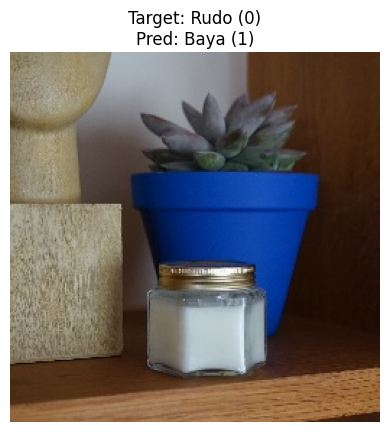

True class: Rudo
Predicted class: Baya
Correct: ✗


In [19]:
# Get random instance
image, target = test_data.__getitem__(3)  # Change index as needed (0-79)

# Format target
target = torch.argmax(target).item()
target_name = plant_names[target]

# Get prediction
input_tensor = image.unsqueeze(0).to(device)
output = model(input_tensor)
pred = torch.argmax(output).item()
pred_name = plant_names[pred]

# Display prediction
rgb_image = image.permute(1, 2, 0).numpy()
plt.imshow(rgb_image)
plt.title(f"Target: {target_name} ({target})\nPred: {pred_name} ({pred})")
plt.axis('off')
plt.show()

print(f"True class: {target_name}")
print(f"Predicted class: {pred_name}")
print(f"Correct: {'✓' if pred == target else '✗'}")


## Canny edge detection

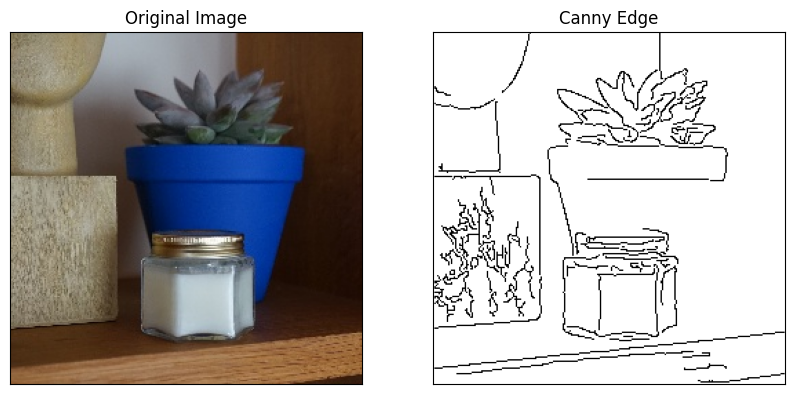

In [20]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(rgb_image)
ax[0].set_title("Original Image")

edge= get_edge(rgb_image, sigma=1, as_image=True)

ax[1].imshow(edge, cmap='gray')
ax[1].set_title("Canny Edge")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

In [21]:
def plot_gradcam(rgb_image, visulaization,title='Input'):

    """Display the original image and the GradCAM heatmap"""

    fig, ax = plt.subplots(1,2,figsize=(10,5))

    ax[0].imshow(rgb_image)
    ax[0].set_title(title)

    ax[1].imshow(visulaization)
    ax[1].set_title("GradCAM Heatmap")

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

## GradCAM

In [22]:

class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category
    
    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]



Heatmap shape: (1, 256, 256)
Heatmap min: 0.0000, max: 1.0000


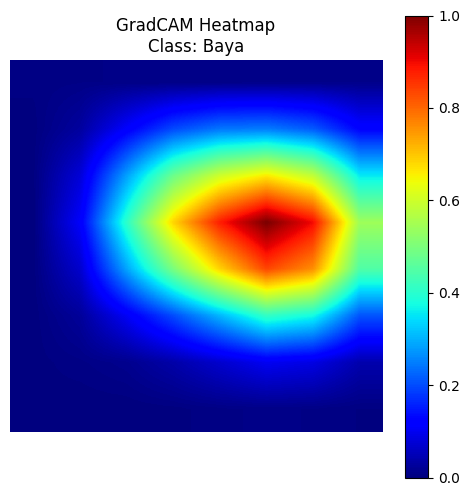

In [43]:
# Define the target layer and class of interest
# For ResNet18: use model.layer4[-1] (last conv layer)
classes = [ClassifierOutputTarget(pred)]  # Use predicted class
layers = [model.layer4[-1]]  # ResNet18's last conv layer

# Get the GradCAM heatmap using YOUR implementation
cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)

print(f"Heatmap shape: {heatmap.shape}")
print(f"Heatmap min: {heatmap.min():.4f}, max: {heatmap.max():.4f}")

# Display raw heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap[0], cmap='jet')
plt.title(f"GradCAM Heatmap\nClass: {pred_name}")
plt.axis('off')
plt.colorbar()
plt.show()


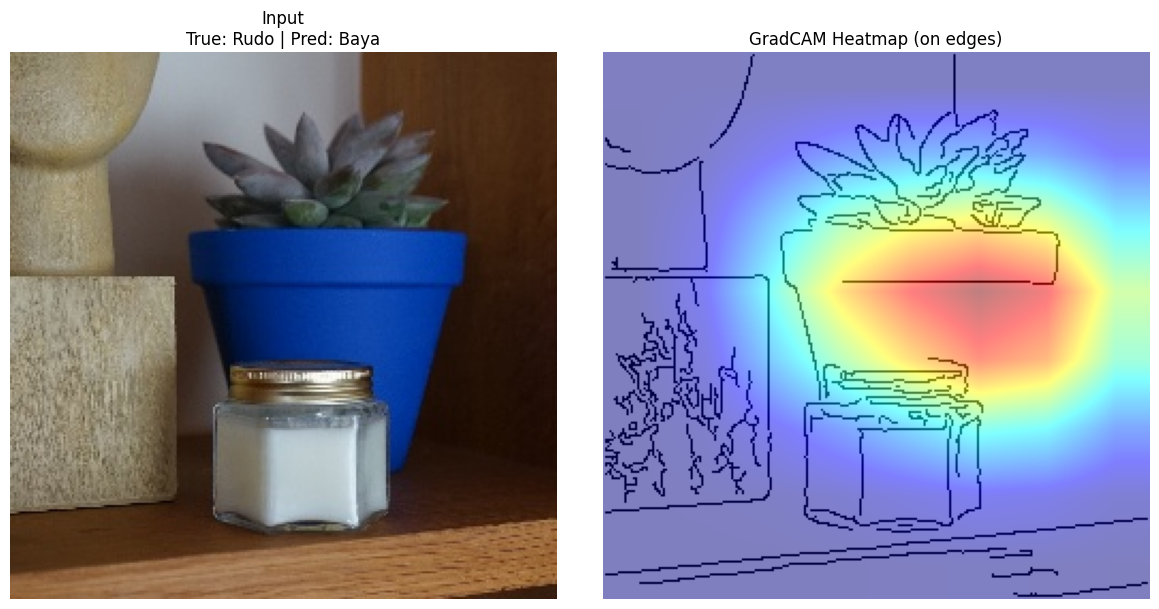

In [45]:
# Plot the heatmap with edge detection
edge = get_edge(rgb_image, sigma=1, as_image=True)
visualization = show_cam_on_image(edge, heatmap[0], use_rgb=True)

# Define plot function
def plot_gradcam(rgb_image, visualization, title='Input'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(rgb_image)
    ax[0].set_title(f"{title}\nTrue: {target_name} | Pred: {pred_name}")
    ax[0].axis('off')
    
    ax[1].imshow(visualization)
    ax[1].set_title("GradCAM Heatmap (on edges)")
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_gradcam(rgb_image, visualization)


Using 4 layers for GradCAM
Combined heatmap shape: (1, 256, 256)


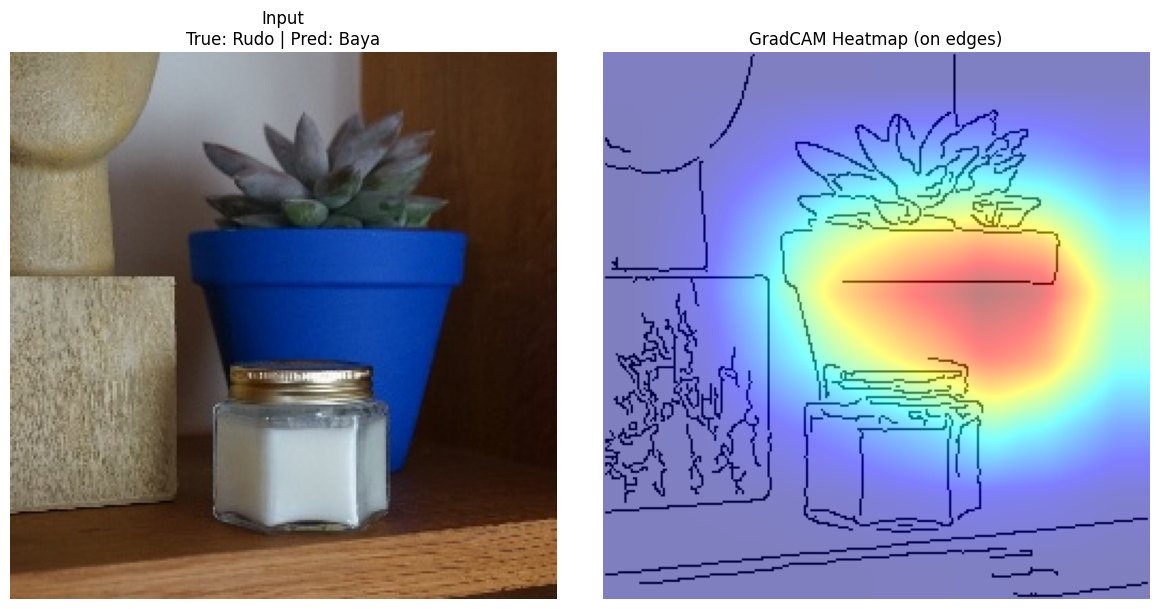

In [47]:
# Multiple layers - ResNet18 has layer1, layer2, layer3, layer4
# Each layer has multiple blocks, we'll use the last block of each

layers = [
    model.layer1[-1],  # First conv block
    model.layer2[-1],  # Second conv block
    model.layer3[-1],  # Third conv block
    model.layer4[-1]   # Fourth conv block (deepest)
]

print(f"Using {len(layers)} layers for GradCAM")

# Get combined heatmap for all layers
cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)

print(f"Combined heatmap shape: {heatmap.shape}")

# Plot the heatmap
edge = get_edge(rgb_image, sigma=1, as_image=True)
visualization = show_cam_on_image(edge, heatmap[0], use_rgb=True)
plot_gradcam(rgb_image, visualization)


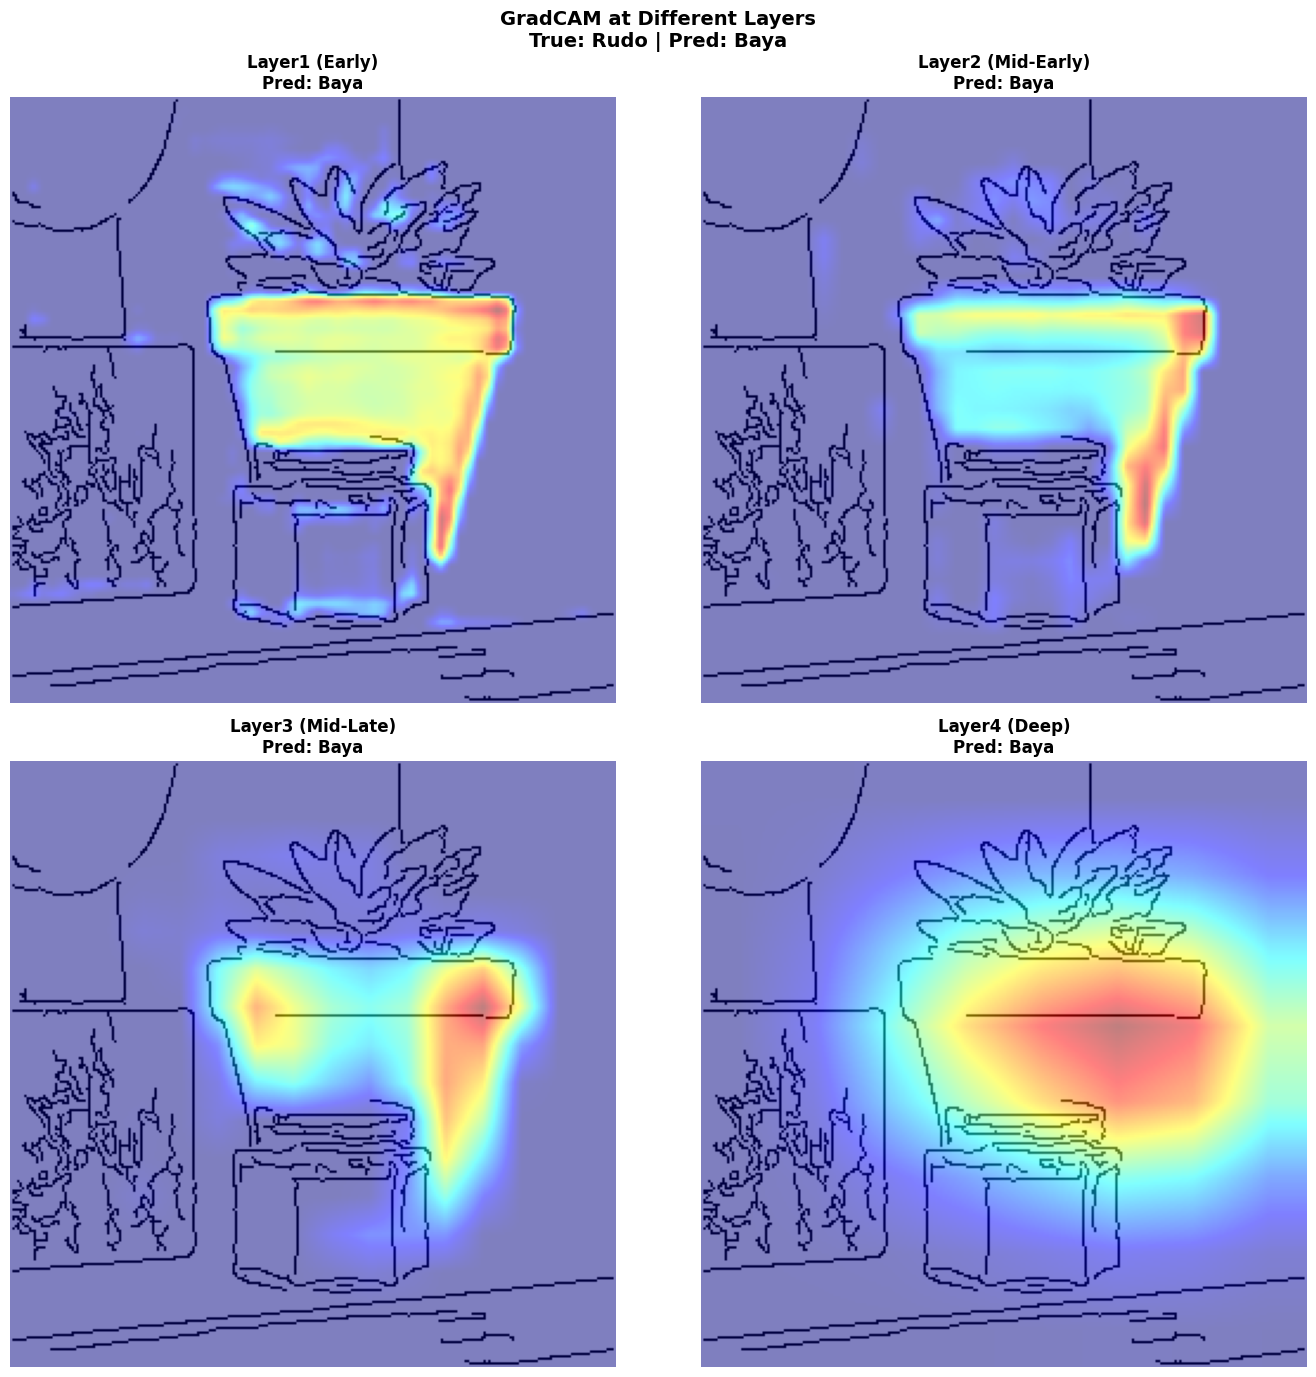

✓ Multi-layer GradCAM visualization complete!


In [48]:
# Get separate visualizations for each layer
layer_names = ['Layer1 (Early)', 'Layer2 (Mid-Early)', 'Layer3 (Mid-Late)', 'Layer4 (Deep)']
layers = [model.layer1[-1], model.layer2[-1], model.layer3[-1], model.layer4[-1]]

maps = []
for layer, name in zip(layers, layer_names):
    cam = GradCAM(model=model, target_layers=[layer])
    heatmap = cam(input_tensor=input_tensor, targets=classes)
    
    edge = get_edge(rgb_image, sigma=1, as_image=True)
    visualization = show_cam_on_image(edge, heatmap[0], use_rgb=True)
    maps.append(visualization)

# Visualize all layers
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for i, (vis, name) in enumerate(zip(maps, layer_names)):
    axes[i].imshow(vis)
    axes[i].set_title(f"{name}\nPred: {pred_name}", fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle(f"GradCAM at Different Layers\nTrue: {target_name} | Pred: {pred_name}", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Multi-layer GradCAM visualization complete!")



Processing class 0: Rudo
  Found 20 images


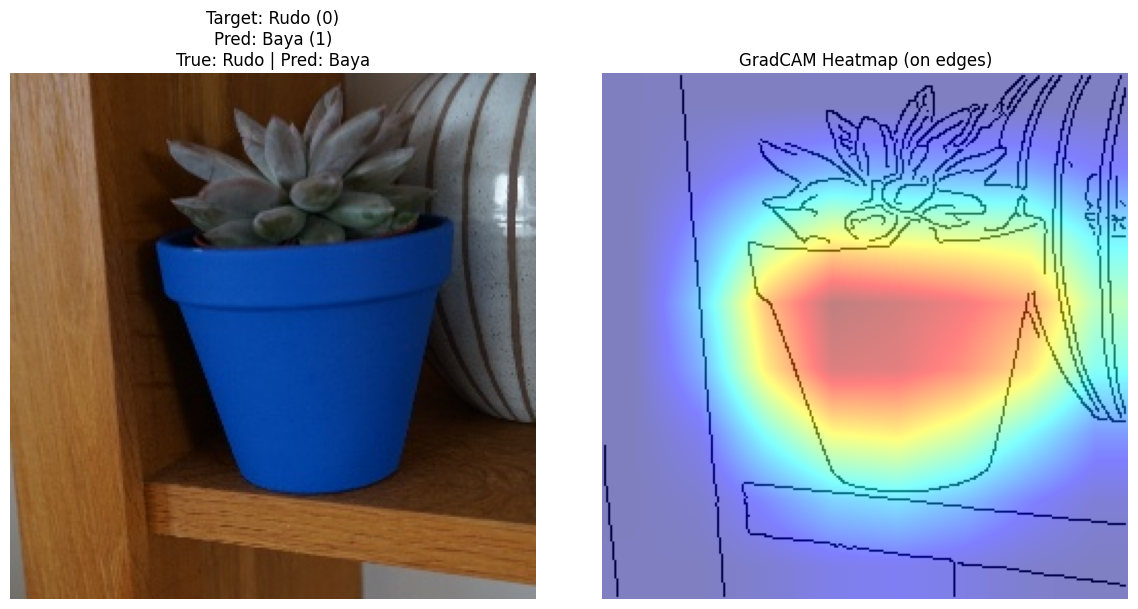

  ✗ Wrong prediction (predicted Baya)

Processing class 1: Baya
  Found 20 images


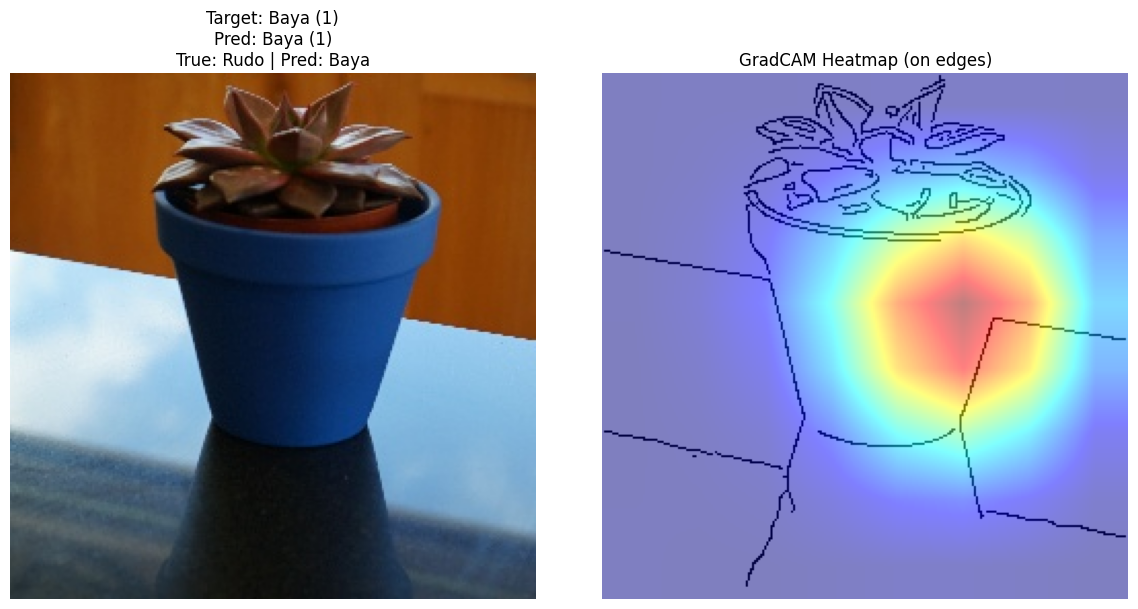

  ✓ Correct prediction!

Processing class 2: Greg
  Found 20 images


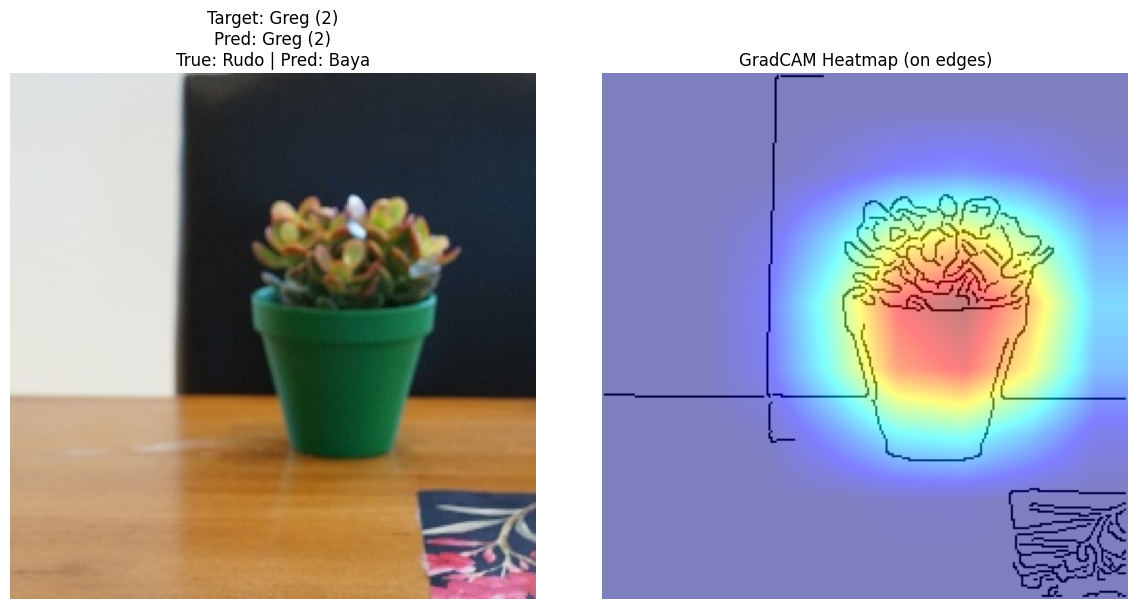

  ✓ Correct prediction!

Processing class 3: Yuki
  Found 20 images


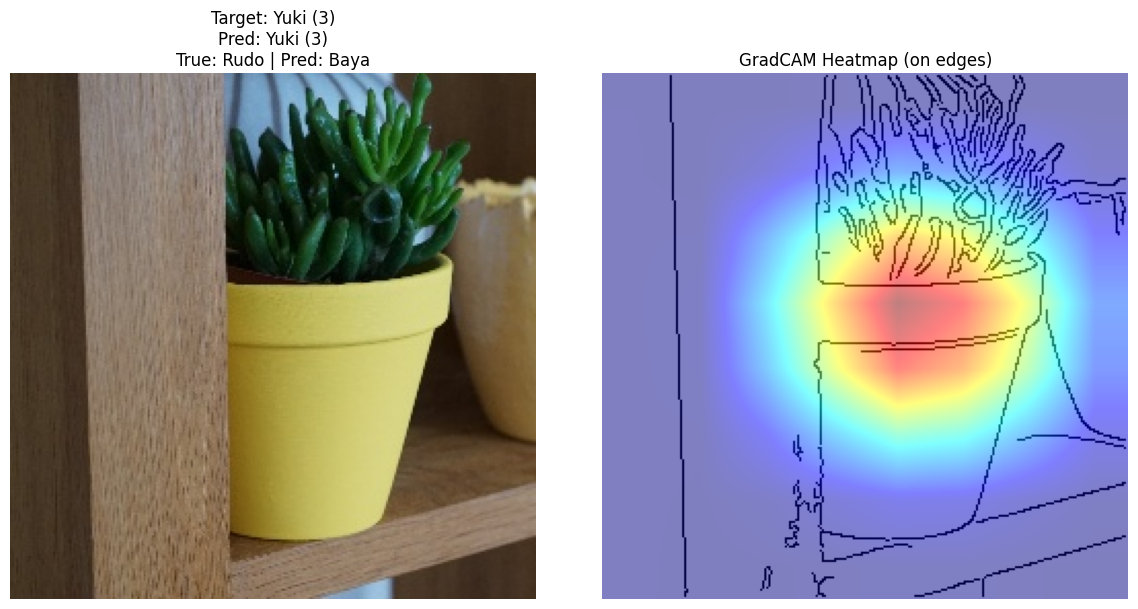

  ✓ Correct prediction!


In [54]:
# Iterate through all plant classes and visualize GradCAM
import numpy as np

for p in [0, 1, 2, 3]:
    print(f"\nProcessing class {p}: {plant_names[p]}")
    
    # Get the paths for given class
    paths = glob.glob(f"./test/{p}_*.jpg")
    
    if len(paths) == 0:
        print(f"  ⚠ No images found for class {p}")
        continue
    
    print(f"  Found {len(paths)} images")
    
    # Get random instance
    np.random.shuffle(paths)
    data = ImageDataset(paths, num_classes=num_classes)
    image, target = data.__getitem__(0)
    
    # Format target
    target = torch.argmax(target).item()
    
    # Get prediction
    input_tensor = image.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred = torch.argmax(output).item()
    
    # Use prediction as target class
    classes = [ClassifierOutputTarget(pred)]
    layers = [model.layer4[-1]]  # ResNet18's last conv layer (instead of conv_layers[6])
    
    # Get heatmap using YOUR custom GradCAM
    cam = GradCAM(model=model, target_layers=layers)
    heatmap = cam(input_tensor=input_tensor, targets=classes)
    
    # Display
    rgb_image = image.permute(1, 2, 0).numpy()
    edge = get_edge(rgb_image, sigma=1, as_image=True)
    visualization = show_cam_on_image(edge, heatmap[0], use_rgb=True)
    
    title = f"Target: {plant_names[target]} ({target})\nPred: {plant_names[pred]} ({pred})"
    plot_gradcam(rgb_image, visualization, title)
    
    # Print prediction accuracy for this sample
    if pred == target:
        print(f"  ✓ Correct prediction!")
    else:
        print(f"  ✗ Wrong prediction (predicted {plant_names[pred]})")


Analyzing: 0_cafefa5f668e62183b8f.jpg

True class: Rudo (0)
Predicted class: Baya (1)

Confidence scores:
  Rudo: 0.09%
  Baya: 99.89%
  Greg: 0.01%
  Yuki: 0.01%


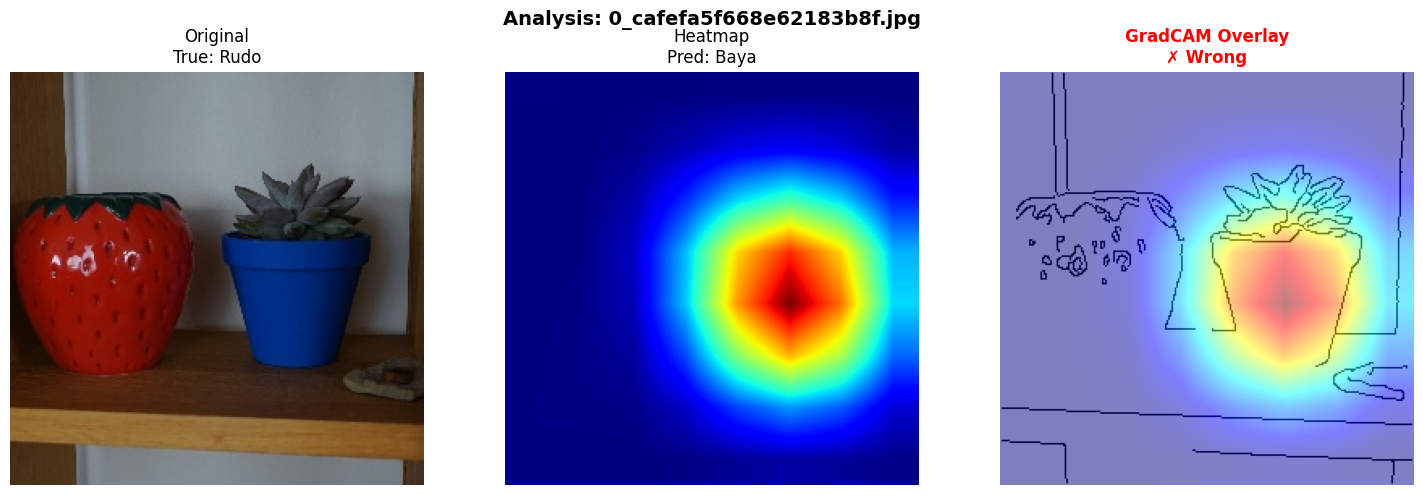


✓ GradCAM analysis complete!


In [62]:
# Test specific image with GradCAM
image_filename = "0_cafefa5f668e62183b8f.jpg"
image_path = f"./test/{image_filename}"

print(f"Analyzing: {image_filename}\n")

# Load image
data = ImageDataset([image_path], num_classes=4)
image, target = data.__getitem__(0)

# Get labels
target_idx = torch.argmax(target).item()
target_name = plant_names[target_idx]

# Get prediction (NO torch.no_grad() here - GradCAM needs gradients!)
input_tensor = image.unsqueeze(0).to(device)
output = model(input_tensor)
pred_idx = torch.argmax(output).item()
pred_name = plant_names[pred_idx]

# Get confidence scores
confidences = torch.softmax(output, dim=1)[0]
print(f"True class: {target_name} ({target_idx})")
print(f"Predicted class: {pred_name} ({pred_idx})")
print(f"\nConfidence scores:")
for i, name in enumerate(plant_names):
    print(f"  {name}: {confidences[i].item()*100:.2f}%")

# Generate GradCAM
classes = [ClassifierOutputTarget(pred_idx)]
layers = [model.layer4[-1]]

cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)

# Visualize
rgb_image = image.permute(1, 2, 0).numpy()
edge = get_edge(rgb_image, sigma=1, as_image=True)
visualization = show_cam_on_image(edge, heatmap[0], use_rgb=True)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rgb_image)
axes[0].set_title(f"Original\nTrue: {target_name}")
axes[0].axis('off')

axes[1].imshow(heatmap[0], cmap='jet')
axes[1].set_title(f"Heatmap\nPred: {pred_name}")
axes[1].axis('off')

color = 'green' if pred_idx == target_idx else 'red'
axes[2].imshow(visualization)
axes[2].set_title(f"GradCAM Overlay\n{'✓ Correct' if pred_idx == target_idx else '✗ Wrong'}", 
                 color=color, fontweight='bold')
axes[2].axis('off')

plt.suptitle(f"Analysis: {image_filename}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ GradCAM analysis complete!")


Analyzing: 2_0c4067ea2cb2cc664wiwiwiw.jpg

True class: Greg (2)
Predicted class: Rudo (0)

Confidence scores:
  Rudo: 52.49%
  Baya: 7.63%
  Greg: 29.46%
  Yuki: 10.41%


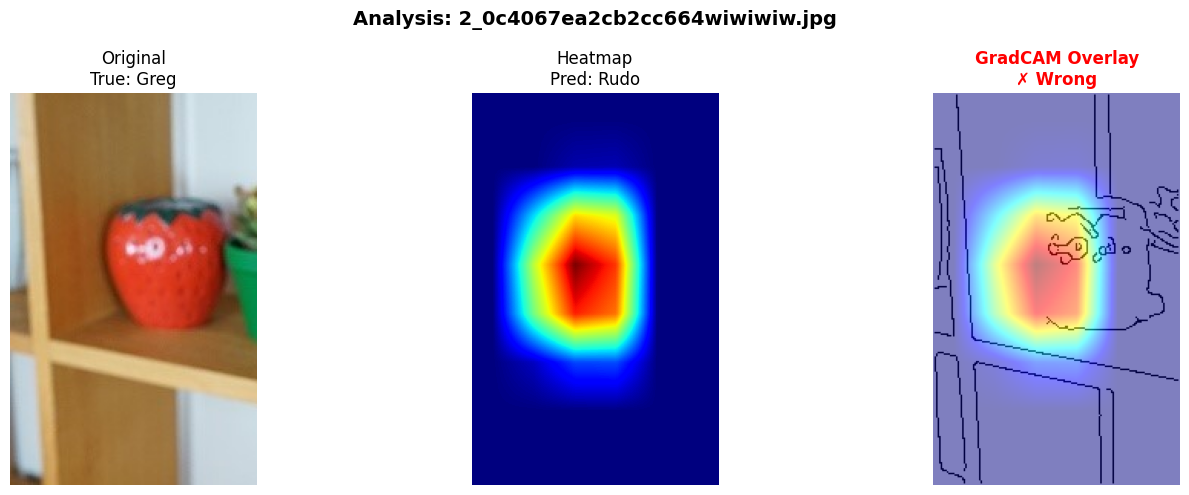


✓ GradCAM analysis complete!


In [72]:
# Test specific image with GradCAM
image_filename = "2_0c4067ea2cb2cc664wiwiwiw.jpg"
image_path = f"./test/{image_filename}"

print(f"Analyzing: {image_filename}\n")

# Load image
data = ImageDataset([image_path], num_classes=4)
image, target = data.__getitem__(0)

# Get labels
target_idx = torch.argmax(target).item()
target_name = plant_names[target_idx]

# Get prediction (NO torch.no_grad() here - GradCAM needs gradients!)
input_tensor = image.unsqueeze(0).to(device)
output = model(input_tensor)
pred_idx = torch.argmax(output).item()
pred_name = plant_names[pred_idx]

# Get confidence scores
confidences = torch.softmax(output, dim=1)[0]
print(f"True class: {target_name} ({target_idx})")
print(f"Predicted class: {pred_name} ({pred_idx})")
print(f"\nConfidence scores:")
for i, name in enumerate(plant_names):
    print(f"  {name}: {confidences[i].item()*100:.2f}%")

# Generate GradCAM
classes = [ClassifierOutputTarget(pred_idx)]
layers = [model.layer4[-1]]

cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)

# Visualize
rgb_image = image.permute(1, 2, 0).numpy()
edge = get_edge(rgb_image, sigma=1, as_image=True)
visualization = show_cam_on_image(edge, heatmap[0], use_rgb=True)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rgb_image)
axes[0].set_title(f"Original\nTrue: {target_name}")
axes[0].axis('off')

axes[1].imshow(heatmap[0], cmap='jet')
axes[1].set_title(f"Heatmap\nPred: {pred_name}")
axes[1].axis('off')

color = 'green' if pred_idx == target_idx else 'red'
axes[2].imshow(visualization)
axes[2].set_title(f"GradCAM Overlay\n{'✓ Correct' if pred_idx == target_idx else '✗ Wrong'}", 
                 color=color, fontweight='bold')
axes[2].axis('off')

plt.suptitle(f"Analysis: {image_filename}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ GradCAM analysis complete!")
